In [16]:
import re
import timeit
import math

from imgdataconvertcodegen.image_data import get_input_image_and_expected_output, set_image_dim

set_image_dim(2000, 2000)
def execute_time_cost(source, target, conversion, repeat_count=10):
    try:
        source_image, _ = get_input_image_and_expected_output(source, target)
    except Exception as e:
        # If the conversion function cannot be executed, return infinity, for example, there is no tensorflow gpu
        # support in the environment.
        return math.inf
    setup = f"{conversion[0]}\n{conversion[1]}"
    func_name = re.search(r'(?<=def )\w+', conversion[1]).group(0)
    code = f"actual_image = {func_name}(source_image)"
    try:
        execution_time = timeit.timeit(stmt=code, setup=setup, number=repeat_count, globals=locals())
    except Exception as e:
        raise RuntimeError(f'{e}, \ncode is {code}\nsetup is {setup}')
    return execution_time / repeat_count

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def is_code_exec_on_cpu(edge):
    return edge[0]['device'] == 'cpu' and edge[1]['device'] == 'cpu'

def hist(data, title, interval=0.1):
    bins = np.arange(0, max(data) + interval, interval)
    n, bins, patches = plt.hist(data, bins=bins, alpha=0.7, rwidth=0.85)
    for patch in patches:
        height = patch.get_height()
        plt.annotate(f'{int(height)}',
                     (patch.get_x() + patch.get_width() / 2, height),
                     textcoords="offset points",
                     xytext=(0,5),
                     ha='center')
    plt.title(title)
    plt.xlabel('Execution Time (s)')
    plt.ylabel('Number')
    plt.show()

In [12]:
from imgdataconvertcodegen import _code_generator, _constructor

kg = _code_generator.knowledge_graph
print(kg)

Knowledge Graph with 553 nodes and 6472 edges.


The range of execution time from 3.7999998312443497e-07 to 0.177442328799998


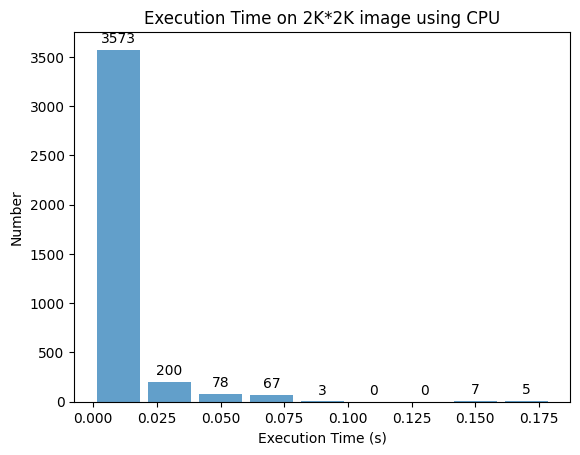

In [13]:
times = []
for edge in kg.edges:
    if is_code_exec_on_cpu(edge):
        conversion = kg.get_edge_data(edge[0], edge[1])['conversion']
        times.append(execute_time_cost(edge[0], edge[1], conversion))
print(f'The range of execution time from {min(times)} to {max(times)}')
hist(times, "Execution Time on 2K*2K image using CPU", 0.02)

The range of execution time from 2.300000005561742e-06 to 0.023188272000015785


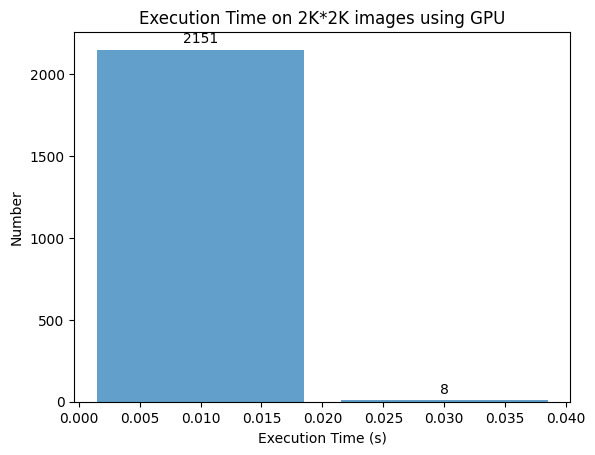

In [14]:
import math

def is_code_exec_on_gpu(edge):
    return edge[0]['device'] == 'gpu' and edge[1]['device'] == 'gpu'

times = []
for edge in kg.edges:
    if is_code_exec_on_gpu(edge):
        conversion = kg.get_edge_data(edge[0], edge[1])['conversion']
        times.append(execute_time_cost(edge[0], edge[1], conversion))
print(f'The range of execution time from {min(times)} to {max(times)}')
hist(times, "Execution Time on 2K*2K images using GPU", 0.02)

The range of execution time from 3.699999979289714e-07 to 0.16650285700002315


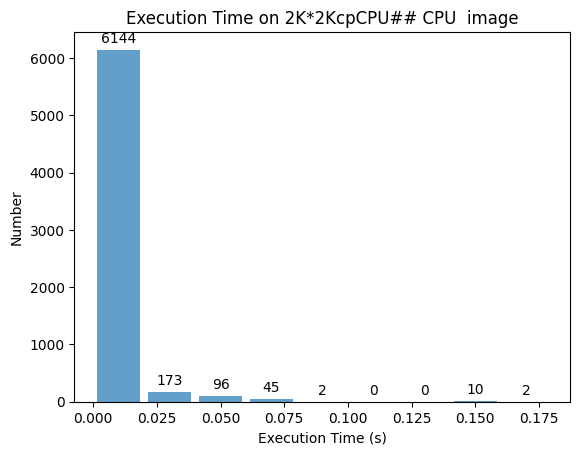

In [15]:
times = []
for edge in kg.edges:
    conversion = kg.get_edge_data(edge[0], edge[1])['conversion']
    times.append(execute_time_cost(edge[0], edge[1], conversion))

print(f'The range of execution time from {min(times)} to {max(times)}')
hist(times, "Execution Time on 2K* image", 0.02)